In [4]:
from string import *
from sys import argv
from Bio import File
from Bio import SeqIO
import sys
import tempfile
import os
from os import system
import subprocess

In [5]:
NN_bin = './disembl'
SG_bin = './sav_gol'

def JensenNet(sequence):
    outFile = tempfile.mktemp()
    inFile= tempfile.mktemp()
    
    open(inFile,'w').write(sequence+'\n')
    #inFile = 'OC1.txt'
    #outFile ='OC2.txt'
    system(NN_bin + '< ' + inFile +' >' + outFile)
    REM465 = []
    COILS = []
    HOTLOOPS = []
    resultsFile = open(outFile,'r')
    results = resultsFile.readlines()
    resultsFile.close()
    for result in results:
        result =result.split()
        coil = round(float(result[0]),6)
        COILS.append(coil)
        hotloop = round(float(result[1]),6)
        HOTLOOPS.append(hotloop)
        rem465 = round(float(result[2]),6)
        REM465.append(rem465)
    os.remove(inFile)
    os.remove(outFile)
    return COILS, HOTLOOPS, REM465

def getSlices(NNdata, fold, join_frame, peak_frame, expect_val):
    slices = []
    inSlice = 0
    for i in range(len(NNdata)):
        if inSlice:
            if NNdata[i] < expect_val:
                if maxSlice >= fold*expect_val:
                    slices.append([beginSlice, endSlice])
                inSlice = 0
            else:
                endSlice += 1
                if NNdata[i] > maxSlice:
                    maxSlice = NNdata[i]
        elif NNdata[i] >= expect_val:
            beginSlice = i
            endSlice = i
            inSlice = 1
            maxSlice = NNdata[i]
    if inSlice and maxSlice >= fold*expect_val:
        slices.append([beginSlice, endSlice])

    i = 0
    while i < len(slices):
        if i+1 < len(slices) and slices[i+1][0]-slices[i][1] <= join_frame:
            slices[i] = [ slices[i][0], slices[i+1][1] ]
            del slices[i+1]
        elif slices[i][1]-slices[i][0]+1 < peak_frame:
            del slices[i]
        else:
            i += 1
    return slices


def reportSlicesTXT(slices, sequence):
    if slices == []:
        s = sequence.lower()
    else:
        if slices[0][0] > 0:
            s = (sequence[0:slices[0][0]]).lower()
        else:
            s = ''
        for i in range(len(slices)):
            if i > 0:
                sys.stdout.write(', ')
            sys.stdout.write( str(slices[i][0]+1) + '-' + str(slices[i][1]+1) )
            s = s + (sequence[slices[i][0]:(slices[i][1]+1)]).upper()
            if i < len(slices)-1:
                s = s + (sequence[(slices[i][1]+1):(slices[i+1][0])]).lower()
            elif slices[i][1] < len(sequence)-1:
                s = s + (sequence[(slices[i][1]+1):(len(sequence))]).lower()
    print ('')
    print (s)

def new_smooth(window,derivative,predicted_raw):
    if len(predicted_raw) < 2*window:
        window = len(predicted_raw)/2
    elif window == 0:
        window = 1
    outFile = tempfile.mktemp()
    inFile= tempfile.mktemp() 
    #inFile = 'oc1_test.txt'
    #outFile ='oc1_test_result.txt'
    with open(inFile, 'w') as filehandle:
        for e in predicted_raw:
            filehandle.write('%s\n' % e)   
    system_call = SG_bin + ' -V0 -D' + str(derivative) + ' -n' + str(window)+','+str(window) + ' '+ inFile + ' >' + outFile
    
    system(system_call)
    SG_results = []
    resultsFile = open(outFile,'r')
    results = resultsFile.readlines()
    resultsFile.close()
    
    for result in results:         
        temp = round(float(result),6)
        SG_results.append(temp)    
    os.remove(outFile)
    os.remove(inFile)
    return SG_results

In [6]:
smooth_frame = 8
peak_frame = 8
join_frame = 4
fold_coils = 1.4
fold_hotloops = 1.2
fold_rem465 = 1.2
sequence = 'STVSDKFPHHHHHHHHHHHPHHHQRLAGNVSGSFTLMRDE'
COILS_raw, HOTLOOPS_raw, REM465_raw = JensenNet(sequence)
COILS_smooth = new_smooth(smooth_frame,0,COILS_raw)

### We will use genetic algorithm. So now define the methods to make different mutations.
## Do not forget to remove the random seed.
use python list instead of numpy because list allow me to pop and insert easily. 
Each seq is very small, so right now I do not worry about the Memory and the Speed

All the index will follow python rule instead of biology

In [177]:
import random

# set seed for now. 
random.seed(0)

def generate_parents(sequence,num_parents=50): # by default get 50 seq as the parents
    """generate parents for the GA by random shuffling the seq"""
    count  = 0
    parents = set()
    if not sequence:
        print('you do not have input')
        return
    while True:
        temp = list(sequence) 
        random.shuffle(temp)
        temp =''.join(temp)
        if temp not in parents:
            parents.add(temp)
            count += 1
        if count == num_parents:
            break
    return list(parents)

def point_transpose(seq, position):
    """given a position, we move the amino acid in that position to a random place"""
    if not seq or position < 0:
        print('illegal input, seq empty or position is minus')
        return
    temp = list(seq)
    good_mutation = False
    amino_acid = temp.pop(position) # pop the amino acid at the position
    all_pos = list(range(len(temp)))  # all positions from 1,2,3... end of the list
    all_pos.remove(position) # remove the position from which we pop the amino acide
    
    if not good_mutation:
        new_pos = random.choice(all_pos) # choose new pos by random    
        temp.insert(new_pos, aa) # insert the aa into the new postion
        temp = ''.join(temp)
        if temp != seq:
            good_mutation = True
    # do we want to have a new one?
    return temp
    

def frag_transpose(seq,start,stop,to_shuffle):
    if not seq or (start < 0) or (stop-start <=0) or stop >= len(seq): # I do not want to use index more that the range
        print('illegal input, seq empty or start and stop positions are wrong')
        return
     
    temp = list(seq)
    good_mutation = False
    try:
        frag = temp[start: stop+1]  # pop from temp
        left_over = temp[:start] + temp[stop+1:]
    except:
        print("""cannot retrive the frag,the length of the original list is {}, 
                your start is {}, and your stop is: {} """.format(len(temp),start,stop))
        return

    all_pos = list(range(len(left_over)))   
    all_pos.remove(start) # we do not want to be in the same 
    while not good_mutation:
        new_start = random.choice(all_pos)
        if to_shuffle:
            random.shuffle(frag)
        #print(frag)
        new_seq = left_over[:new_start] + frag + left_over[new_start:]
        new_seq =''.join(new_seq)
        if new_seq != seq:
            good_mutation = True
    return new_seq

def frag_disperse(seq, start, stop):
    """ this one we will just disperse the orginal frag into a new list

    """
    
    if not seq or (start < 0) or (stop-start <=0) or stop >= len(seq): # I do not want to use index more that the range
        print('illegal input, seq empty or start and stop positions are wrong')
        return
    
    good_mutation = False
    temp = list(seq)
    frag = temp[start:stop+1]
    random.shuffle(frag)
    left_over = temp[:start] + temp[stop+1:]
    all_pos = list(range(len(left_over)))   
    
    while not good_mutation:
        pos_needed = random.sample(all_pos, k = stop-start+1)
        pos_needed.sort(reverse = True) # sort it so I can insert from the revese manner
        print(pos_needed)
        for idx, element in zip(pos_needed,frag):
            left_over.insert(idx, element)
        if left_over != seq:
            good_mutation = True
            
    return left_over
    
    
    
    

In [131]:
s = 'RKHFREV'
print(s)
print(frag_disperse(s,2,4))

RKHFREV
[3, 1, 0]
['R', 'R', 'F', 'K', 'E', 'H', 'V']


### Now we will have a function to calculate the fitness score,identify the position with the highest score

In [182]:
#

In [206]:
import numpy as np

def fitness_one(seq, to_plot = False):
    smooth_frame = 8
    _, _, raw = JensenNet(seq)
    temp_smooth = new_smooth(smooth_frame,0, raw)
    if to_plot:
        plt.plot(temp_smooth)
        plt.axhline(y = 0.5)
        plt.axvline(x = np.argmax(temp_smooth))
        plt.grid()
        plt.title('Disorder of '+ sequence)
        plt.text(0,0.35, 'mean disorder: {}'.format(round(np.mean(temp_smooth),3)))
        plt.text(np.argmax(temp_smooth)+1,max(temp_smooth)-0.05,'max:{}'.format(round(max(temp_smooth),3)))
    return seq, np.mean(temp_smooth), np.argmax(temp_smooth),max(temp_smooth)
    

generate 2000 parents 0.05319499969482422


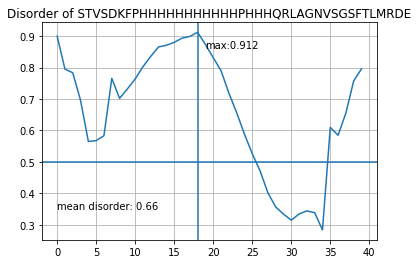

In [216]:
a,b,c,d = fitness_one(sequence, True)
#print(a, b ,c)

seed = 'STVSDKFPHHHHHHHHHHHPHHHQRLAGNVSGSFTLMRDE' # mouse oc1

import time
start = time.time()
test_seq = generate_parents(seed,2000)
end = time.time()

print('generate 2000 parents',end-start)


In [170]:
def scan_population(seqs):
    mean_fit, max_idx, max_fit = [],[],[]
    for seq in seqs:
        _, one_mean_fit, one_max_idx, one_max_fit = fitness_one(seq)
        mean_fit.append(one_mean_fit)
        max_idx.append(one_max_idx)
        max_fit.append(one_max_fit)
    return mean_fit, max_idx, max_fit

In [217]:

a,b,c = scan_population(test_seq)



('QHSPHRHLFAHHMKHTGFTNHSVDRPDHVGHHELHSHHHS', 0.5275054, 0, 0.929287)

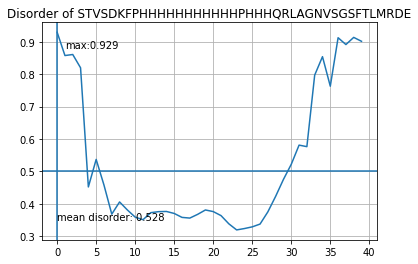

In [218]:
idx = np.argmin(a)
test_seq[idx]

fitness_one(test_seq[idx],True)



('STVSDKFPHHHHHHHHHHHPHHHQRLAGNVSGSFTLMRDE', 0.659527675, 18, 0.912478)

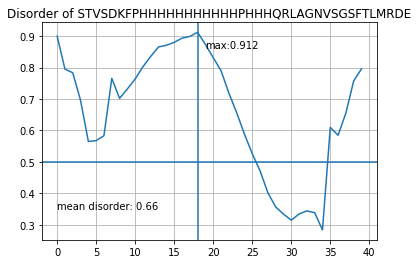

In [219]:
fitness_one(seed,True)

/Users/xiaodong/anaconda3/envs/NYC2020/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


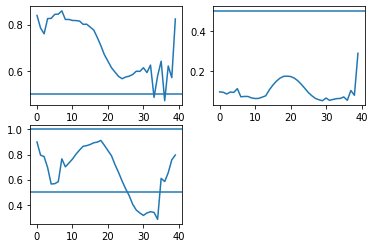

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(221)
ax1=plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax1.plot(COILS_smooth)
ax1.axhline(y=0.5)
ax2.plot(HOTLOOPS_smooth)
ax2.axhline(y=0.5)
ax3.plot(REM465_smooth)
ax3.axhline(y=0.5)
ax3.axhline(y=1)
# The REM465_smooth is the one we loved

In [144]:
print(REM465_smooth[-2])
len(REM465_smooth)

0.757692


40